<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Расчет-прибыли" data-toc-modified-id="Расчет-прибыли-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Расчет прибыли</a></span></li><li><span><a href="#Расчет-прибыли-и-рисков-техникой-Bootstrap" data-toc-modified-id="Расчет-прибыли-и-рисков-техникой-Bootstrap-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Расчет прибыли и рисков техникой Bootstrap</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект: «Выбор локации для скважины»

Нефтедобывающей компании необходимо определить место бурения новой скважины. В нашем распоряжении пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль.

**Стандартные шаги для выбора локации:**

1. В избранном регионе собирают характеристики скважин: качество нефти и объём её запасов.
2. Строят модель для предсказания объёма запасов в новых скважинах.
3. Выбирают скважины с самыми высокими оценками значений.
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

**Цели:**
- Построить модель машинного обучения, с целью определения наиболее прибыльного региона.
- Проанализировать возможную прибыль и провести оценку рисков с использованием техники *Bootstrap*.
- Оставить регионы, в которых вероятность убытков меньше 2.5%. 
- Выбрать регион с наибольшей средней прибылью.

**Описаниме данных:**
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
from math import ceil
from ipywidgets import widgets, Layout
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
random_seed = 17
pd.options.display.float_format = '{:.2f}'.format

In [2]:
try:
    df_1 = pd.read_csv('geo_data_0.csv')
    df_2 = pd.read_csv('geo_data_1.csv')
    df_3 = pd.read_csv('geo_data_2.csv')
    
except FileNotFoundError:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
widget1 = widgets.Output()
widget2 = widgets.Output()
widget3 = widgets.Output()

with widget1:
    display.display(df_1.head(10).style.set_caption('First dataframe'))
    df_1.info(memory_usage='deep')
with widget2:
    display.display(df_2.head(10).style.set_caption('Second dataframe'))
    df_2.info(memory_usage='deep')
with widget3:
    display.display(df_3.head(10).style.set_caption('Third dataframe'))
    df_3.info(memory_usage='deep')

hbox = widgets.HBox([widget1, widget2, widget3])

hbox

In [4]:
for i, df in enumerate([df_1, df_2, df_3]):
    print(f'Число дубликатов в датафрейме {i+1}: {df.duplicated().sum()}')

Число дубликатов в датафрейме 1: 0
Число дубликатов в датафрейме 2: 0
Число дубликатов в датафрейме 3: 0


In [5]:
widget1 = widgets.Output()
widget2 = widgets.Output()
widget3 = widgets.Output()

with widget1:
    display.display(df_1.describe().style.set_caption('First dataframe'))
with widget2:
    display.display(df_2.describe().style.set_caption('Second dataframe'))
with widget3:
    display.display(df_3.describe().style.set_caption('Third dataframe'))

hbox = widgets.HBox([widget1, widget2, widget3])

hbox

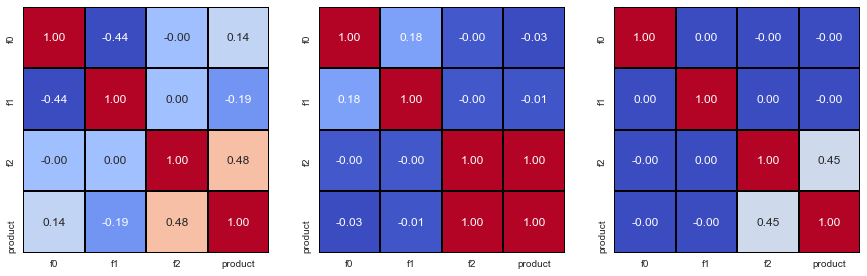

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

ax = sns.heatmap(df_1.corr(), 
            cmap='coolwarm', linewidths=1, linecolor='black', square=True,
            annot=True, fmt='.2f', annot_kws={'size':12}, ax=axes[0], cbar=False);

ax = sns.heatmap(df_2.corr(), 
            cmap='coolwarm', linewidths=1, linecolor='black', square=True,
            annot=True, fmt='.2f', annot_kws={'size':12}, ax=axes[1], cbar=False);

ax = sns.heatmap(df_3.corr(), 
            cmap='coolwarm', linewidths=1, linecolor='black', square=True,
            annot=True, fmt='.2f', annot_kws={'size':12}, ax=axes[2], cbar=False);

**Выводы:**

1. Пространство признаков состоит из *3* числовых признаков.
2. Исходные таблицы не содержат пропущенных и повторяющихся значений.
3. Опираясь на описательнаю статистику количественных признаков обнаружено присутствие экстремальных значений, однако не имея представления о значении признаков сложно оценить адекватность распределения и выбросов.
4. Целевой признак `product` не содержит отрицательных значений.
5. Значения признаков лежат в одном числовом диапазоне, таким образом в масштабировании данных нет необходимости.
6. Мультиколлинеарность между независимыми признаками не обнаружена. Однако стоит отметить следующее:
    - `df_1` — коэффициент корреляции между признаками `f0` и `f1` *-0.44*;
    - `df_1` — коэффициент корреляции между признаком `f2` и целевым признаком `product` *0.48*;
    - `df_2` — коэффициент корреляции между признаком `f2` и целевым признаком `product` *1*;
    - `df_3` — коэффициент корреляции между признаком `f2` и целевым признаком `product` *0.45*.

## Моделирование

**Необходимо** обучить и проверить модель линейной регрессии для каждого региона.

In [7]:
def modeling(df):
    
    features = df[['f0', 'f1', 'f2']]
    target = df['product']
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                test_size = 0.25, random_state=random_seed)
    print(f'Размер обучающей выборки: {features_train.shape[0]}')
    print(f'Размер тестовой выборки: {features_test.shape[0]}')
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)

    return target_test, pd.Series(predictions)

In [8]:
def score(target, predictions):
    
    rmse = mean_squared_error(target, predictions)**.5
    r2 = r2_score(target, predictions)
    print(f'Запас предсказанного сырья: {round(predictions.mean(), 4)}')
    print(f'RMSE: {round(rmse, 4)}')
    print(f'R2-score: {round(r2, 4)}')

In [9]:
target_1, predictions_1 = modeling(df_1)
score(target_1, predictions_1)

Размер обучающей выборки: 75000
Размер тестовой выборки: 25000
Запас предсказанного сырья: 92.3906
RMSE: 37.786
R2-score: 0.273


In [10]:
target_2, predictions_2 = modeling(df_2)
score(target_2, predictions_2)

Размер обучающей выборки: 75000
Размер тестовой выборки: 25000
Запас предсказанного сырья: 68.8194
RMSE: 0.8868
R2-score: 0.9996


In [11]:
target_3, predictions_3 = modeling(df_3)
score(target_3, predictions_3)

Размер обучающей выборки: 75000
Размер тестовой выборки: 25000
Запас предсказанного сырья: 95.0858
RMSE: 40.143
R2-score: 0.1978


**Выводы:**

- Запасы предсказанного сырья по регионам 1, 2 и 3, *92.39*, *68.82* и *95.09 тыс. баррелей*, соответственно. Полученные моделированием данные соответствуют средним значениям запасов сырья всех скважин в разрезе каждого региона.
- *RMSE* и *R2-score* моделей обученных на характеристиках скважин регионов 1, 2 и 3 следующие: *37.79 тыс. баррелей* и *0.273*, *0.887 тыс. баррелей* и *0.9996*, *40.14 тыс. баррелей* и *0.198*.
- Таким образом линейная модель регрессии, обученная на признаках, отражающих характеристики скважин во втором регионе, обладает наибольшей точностью, что является следствием сильной корреляции признака `f2`и целевой переменной.

## Подготовка к расчёту прибыли

**Необходимо:** 
1. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. 
2. Сравнить полученный объём сырья со средним запасом в каждом регионе.

- бюджет на разработку скважин в регионе — 10 млрд рублей;
- количество потенциальных скважин на разработку — 200;
- цена одного барреля нефти 450 рублей — таким образом с каждой единицы продукта доход составляет 450 тыс. рублей.

In [12]:
BUDGET = 1e10
PRICE = 450e3
POINTS = 200
result = ceil((BUDGET/POINTS)/PRICE)
print(f'Минимальный необходимый объём сырья с одной скважины для безубыточной разработки: {result} тыс. баррелей')

Минимальный необходимый объём сырья с одной скважины для безубыточной разработки: 112 тыс. баррелей


In [13]:
for i, df in enumerate([df_1, df_2, df_3]):
    if df['product'].mean() >= result:
        print(f"Средний объем сырья в регионе {i+1} равен {int(df['product'].mean())}, что больше  минимального необходимого объёма")
    else:
        print(f"Средний объем сырья в регионе {i+1} равен {int(df['product'].mean())}, что меньше  минимального необходимого объёма")

Средний объем сырья в регионе 1 равен 92, что меньше  минимального необходимого объёма
Средний объем сырья в регионе 2 равен 68, что меньше  минимального необходимого объёма
Средний объем сырья в регионе 3 равен 95, что меньше  минимального необходимого объёма


**Выводы:**
1. Минимальный объём сырья для безубыточной разработки составляет *112 тыс. баррелей*.
2. Среднего объема сырья по всем скважинам в разрезе каждого региона недостаточно для безубыточной разработки новых скважин.

## Расчёт прибыли и рисков

### Расчет прибыли

**Необходимо:**
1. Выбрать скважины с максимальными значениями предсказаний.
2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитать прибыль для полученного объёма сырья.

In [14]:
def profit(target, predictions):
    predictions = predictions.reset_index(drop=True).sort_values(ascending=False)[:POINTS]
    target = target.reset_index(drop=True).loc[predictions.index]
    print(f'Средний объем сырья 200 выбраных скважин: {round(target.mean(), 2)} тыс. баррелей')
    print(f'Суммарный объем сырья 200 выбраных скважин: {round(target.sum(), 2)} тыс. баррелей')
    print(f'Потенциальная прибыль: {round((target.sum()*PRICE-BUDGET)/1e9, 2)} млрд. руб.')

In [15]:
print('Регион 1')
print('_'*70, end='\n\n')
profit(target_1, predictions_1)

Регион 1
______________________________________________________________________

Средний объем сырья 200 выбраных скважин: 147.23 тыс. баррелей
Суммарный объем сырья 200 выбраных скважин: 29446.29 тыс. баррелей
Потенциальная прибыль: 3.25 млрд. руб.


In [16]:
print('Регион 2')
print('_'*70, end='\n\n')
profit(target_2, predictions_2)

Регион 2
______________________________________________________________________

Средний объем сырья 200 выбраных скважин: 137.95 тыс. баррелей
Суммарный объем сырья 200 выбраных скважин: 27589.08 тыс. баррелей
Потенциальная прибыль: 2.42 млрд. руб.


In [17]:
print('Регион 3')
print('_'*70, end='\n\n')
profit(target_3, predictions_3)

Регион 3
______________________________________________________________________

Средний объем сырья 200 выбраных скважин: 136.67 тыс. баррелей
Суммарный объем сырья 200 выбраных скважин: 27334.65 тыс. баррелей
Потенциальная прибыль: 2.3 млрд. руб.


### Расчет прибыли и рисков техникой Bootstrap

**Необходимо:**
1. Применить технику Bootstrap с 1000 выборок, с целью смоделировать распределение выборочных средних прибыли.
2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [18]:
def profit_boot(target, predictions):
    
    predictions = predictions.reset_index(drop=True).sort_values(ascending=False)[:POINTS]
    target = target.reset_index(drop=True).loc[predictions.index]
    return (target.sum() * PRICE - BUDGET)/1e9
            
def bootstrap(target, predictions):
    
    state = np.random.RandomState(random_seed)
    
    bootstrap_samples = 1000
    values = []
    
    for _ in range(bootstrap_samples):
        
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index]
        
        result = profit_boot(target_subsample, predictions_subsample)
        values.append(result)
    
    values = pd.Series(values)
    
    print(f'Средняя прогнозируемая прибыль: {round(values.mean(), 2)} млрд. руб.')
    print(f'Доверительный интервал: {round(values.quantile(0.025), 2)} — {round(values.quantile(0.975), 2)} млрд. руб.')
    print(f'Риск убытков: {round((values < 0).mean()*100, 2)}%')

In [19]:
print('Регион 1')
print('_'*50, end='\n\n')
bootstrap(target_1, predictions_1)

Регион 1
__________________________________________________

Средняя прогнозируемая прибыль: 0.44 млрд. руб.
Доверительный интервал: -0.08 — 0.94 млрд. руб.
Риск убытков: 5.1%


In [20]:
print('Регион 2')
print('_'*50, end='\n\n')
bootstrap(target_2, predictions_2)

Регион 2
__________________________________________________

Средняя прогнозируемая прибыль: 0.43 млрд. руб.
Доверительный интервал: 0.01 — 0.85 млрд. руб.
Риск убытков: 2.2%


In [21]:
print('Регион 3')
print('_'*50, end='\n\n')
bootstrap(target_3, predictions_3)

Регион 3
__________________________________________________

Средняя прогнозируемая прибыль: 0.33 млрд. руб.
Доверительный интервал: -0.21 — 0.87 млрд. руб.
Риск убытков: 12.1%


## Общий вывод

Перед нами стояла задача построить модель для нефтедобывающей компании с целью определения региона, в котором добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой Bootstrap.


1. При проведении первичного анализа данных было обнаружено, что независимый признак `f2` коррелирует с целевой переменной:
    - Регион 1 — коэффициент корреляции между признаком `f2` и целевым признаком `product` *0.48*;
    - Регион 2 — коэффициент корреляции между признаком `f2` и целевым признаком `product` *1*;
    - Регион 3 — коэффициент корреляции между признаком `f2` и целевым признаком `product` *0.45*.
    
    
2. *RMSE* и *R2-score* моделей обученных на характеристиках скважин регионов 1, 2 и 3 были следующими: 

    - 37.79 тыс. баррелей и 0.273; 
    - 0.887 тыс. баррелей и 0.9996; 
    - 40.14 тыс. баррелей и 0.198. 
    
    Таким образом линейная модель регрессии, обученная на признаках, отражающих характеристики скважин в регионе 2, обладает наибольшей точностью, что является следствием сильной корреляции признака `f2` и целевой переменной.
    
    
3. Расчитанный минимальный необходимый объём сырья с одной скважины для безубыточной разработки: *112 тыс. баррелей*.


4. Моделирование распределения выборочных средних прибыли техникой Bootstrap дало следующие результаты:
    - *Регион 1*
        - Средняя прогнозируемая прибыль: 0.44 млрд. руб.
        - Доверительный интервал: -0.08 — 0.94 млрд. руб.
        - Риск убытков: 5.1%
    - *Регион 2*
        - Средняя прогнозируемая прибыль: 0.43 млрд. руб.
        - Доверительный интервал: 0.01 — 0.85 млрд. руб.
        - Риск убытков: 2.2%
    - *Регион 3*
        - Средняя прогнозируемая прибыль: 0.33 млрд. руб.
        - Доверительный интервал: -0.21 — 0.87 млрд. руб.
        - Риск убытков: 12.1%
        
        
5. С учетом полученных результатов наиболее перспективным регионом для разработки скважин является *Регион 2*.